# Regularization: L2 Regularization and Dropout

In this notebook, we'll still use the same kind of neural network:

<img src="../2_L-LayerNN/images/NN.png">

But as we overfitted our training set, this time we'll improve it by using **L2 Regularization** and **Dropout** in our deep learning model.

Actually, we won't improve the results that much as the training set is quite small. Later on, we'll also try data augmentation.

## What to do?

At the end of this notebook, we'll start again the cat example using the regularization techniques.

## Organization of this Notebook 
    1. Packages
    2. Import of images
    3. L2 Regularization
    4. Model construction with L2 Regularization technique
    5. Dropout
    6. Model construction with Dropout technique

## 1 - Packages ##

- [numpy](www.numpy.org): the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org): a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org): a famous library to plot graphs in Python.
- [L_NN](L_NN.py): my own L-layer Neural Network implementation

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from L_NN import sigmoid, d_sigmoid, ReLU, d_ReLU
from L_NN import initialize, globalForwardPropagation, computeCost, predict, updateParameters, model, try_decision
from py_utils import load_dataset # Copy/pasted loader

%matplotlib inline

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2- Import of images ##

In [2]:
training_imgLoaded, training_label, testing_imgLoaded, testing_label, classes = load_dataset()

Here, we reshape and normalize the images to have a $(height*width*3 \text{ x } 1)$ matrix with pixels values between $0$ and $1$.

In [3]:
training_img = training_imgLoaded.reshape(training_imgLoaded.shape[0], -1).T / 255.
testing_img = testing_imgLoaded.reshape(testing_imgLoaded.shape[0], -1).T / 255.

In [4]:
print("Number of pixels: %i" %(training_img.shape[0]))
print("Number of training data: %i" %(training_img.shape[1]))

Number of pixels: 12288
Number of training data: 209


## 3 - L2 Regularization ##

**L2 regularization** consists of modifying the cost function from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \, y^{(i)}log(a^{[L](i)}) + (1-y^{(i)})log(1- a^{[L](i)}) \tag{1}$$
To:
$$J_{regularized} = J + \frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} \tag{2}$$

In [5]:
def computeCostRegularized(parameters, AL, Y, lambd):
    
    usualCost = -np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)) / Y.shape[1]
    
    L2_cost = 0
    L = len(parameters) // 3
    for l in range(L):
        L2_cost = L2_cost + np.sum(np.square(parameters['W' + str(l+1)]))
        
    L2_cost = lambd * L2_cost / (2 * m)
    
    return np.squeeze(usualCost + L2_cost)

The derivatives are now also modified by taking in acount $\frac{\partial}{\partial W^{[l]}} (\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2})$ for each layer l.

Therefore, we go from:
$$\frac{\partial J}{\partial W^{[l]}} = dZ^{[l]} \; A^{[l-1]}\tag{3}$$

To:
$$\frac{\partial J}{\partial W^{[l]}} = dZ^{[l]} \; A^{[l-1]} + \frac{\lambda}{m} W^{[l]}\tag{4}$$

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes.

In [6]:
def backwardPropagationL2Regularized(W_l, Z_l, dA_l, A_l1, actFunction, lambd):
    
    if actFunction == "sigmoid":
        dZ_l = dA_l * d_sigmoid(Z_l)
    elif actFunction == "tanh":
        dZ_l = dA_l * d_tanh(Z_l)
    elif actFunction == "ReLU":
        dZ_l = dA_l * d_ReLU(Z_l)
    elif actFunction == "LReLU":
        dZ_l = dA_l * d_LReLU(Z_l)
    
    dW_l = np.dot(dZ_l, A_l1.T) / A_l1.shape[1] + lambd * W_l / A_l1.shape[1]
    db_l = np.sum(dZ_l, axis = 1, keepdims = True) / A_l1.shape[1]
    dA_l1 = np.dot(W_l.T, dZ_l)
    
    assert(dA_l1.shape == A_l1.shape)
    assert(dW_l.shape == W_l.shape)
    
    return dA_l1, dW_l, db_l

def globalBackwardPropagationL2Regularized(Y, Zs, As, parameters, lambd):
    grads = {}
    L = len(Zs)
    
    # Zs from 1 to L and As from 0 to L
    assert(len(Zs) + 1 == len(As))
    
    # Initializing the backpropagation
    AL = As[L]
    Y = Y.reshape((AL.shape))
    dA_l1 = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    assert(dA_l1.shape == AL.shape)

    # From l=L-1 to l=0, outbox included
    for l in reversed(range(L)):
        dA_l1, dW_l, dB_l = backwardPropagationL2Regularized(parameters["W" + str(l+1)], Zs[l], dA_l1, As[l], parameters["F" + str(l+1)], lambd)
        grads["dW" + str(l + 1)] = dW_l
        grads["db" + str(l + 1)] = dB_l
    return grads

## 4 - Model construction with L2 Regularization technique ##

Let know try with our cat training and test sets

In [21]:
def modelL2Regularized(X, Y, X_test, Y_test, layers_dims, actFunctions, learning_rate = 0.0008, num_iterations = 5000, lambd = 0.7, print_cost = False):
    # Initialize the weights and the bias
    parameters = initialize(layers_dims, actFunctions, print_Dim = print_cost)
    
    costs = []
    
    for i in range(0, num_iterations):

        Zs, As, AL = globalForwardPropagation(X, parameters)
        
        epoch_cost = computeCost(AL, Y)
        
        grads = globalBackwardPropagationL2Regularized(Y, Zs, As, parameters, lambd)
        
        parameters = updateParameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost:
            if i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, epoch_cost))
            if i % 5 == 0:
                costs.append(epoch_cost)
    
    if print_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
    
    # Test the model
    Y_prediction = predict(parameters, X)
    print("train accuracy: "  + str(np.sum( (Y_prediction == Y) / Y.shape[1] )))
    
    Y_prediction_test = predict(parameters, X_test)
    print("test accuracy: "  + str(np.sum( (Y_prediction_test == Y_test) / Y_test.shape[1] )))
    
    return parameters

In [8]:
layerDims = [12288, 20, 7, 5, 1]
actFunctions =  ["ReLU", "ReLU", "ReLU", "sigmoid"]

Cost after epoch 0: 0.878398
Cost after epoch 100: 0.635645
Cost after epoch 200: 0.581357
Cost after epoch 300: 0.530318
Cost after epoch 400: 0.481720
Cost after epoch 500: 0.443488
Cost after epoch 600: 0.409171
Cost after epoch 700: 0.379190
Cost after epoch 800: 0.353856
Cost after epoch 900: 0.330413
Cost after epoch 1000: 0.308823
Cost after epoch 1100: 0.289387
Cost after epoch 1200: 0.269469
Cost after epoch 1300: 0.251870
Cost after epoch 1400: 0.235074
Cost after epoch 1500: 0.220167
Cost after epoch 1600: 0.205796
Cost after epoch 1700: 0.192900
Cost after epoch 1800: 0.181048
Cost after epoch 1900: 0.170122
Cost after epoch 2000: 0.159468
Cost after epoch 2100: 0.149732
Cost after epoch 2200: 0.140174
Cost after epoch 2300: 0.129879
Cost after epoch 2400: 0.120126
Cost after epoch 2500: 0.111336
Cost after epoch 2600: 0.103495
Cost after epoch 2700: 0.096398
Cost after epoch 2800: 0.090162
Cost after epoch 2900: 0.084335
Cost after epoch 3000: 0.079130
Cost after epoch 310

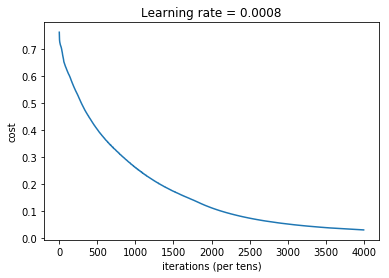

train accuracy: 0.9999999999999998
test accuracy: 0.76


In [9]:
parametersNonRegularized = model(training_img, training_label, testing_img, testing_label, layerDims, actFunctions, print_cost = True)

number of Layers: 4
  1 / W(20, 12288) / b(20, 1) / ReLU
  2 / W(7, 20) / b(7, 1) / ReLU
  3 / W(5, 7) / b(5, 1) / ReLU
  4 / W(1, 5) / b(1, 1) / sigmoid

Cost after iteration 0: 1.135281
Cost after iteration 100: 0.653870
Cost after iteration 200: 0.636635
Cost after iteration 300: 0.623942
Cost after iteration 400: 0.611846
Cost after iteration 500: 0.600340
Cost after iteration 600: 0.589639
Cost after iteration 700: 0.578361
Cost after iteration 800: 0.565494
Cost after iteration 900: 0.552095
Cost after iteration 1000: 0.538585
Cost after iteration 1100: 0.525019
Cost after iteration 1200: 0.511311
Cost after iteration 1300: 0.497383
Cost after iteration 1400: 0.483409
Cost after iteration 1500: 0.469403
Cost after iteration 1600: 0.455015
Cost after iteration 1700: 0.440892
Cost after iteration 1800: 0.426600
Cost after iteration 1900: 0.412190
Cost after iteration 2000: 0.397925
Cost after iteration 2100: 0.383600
Cost after iteration 2200: 0.368465
Cost after iteration 2300: 0.

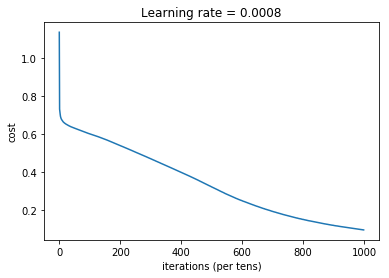

train accuracy: 0.9856459330143539
test accuracy: 0.78


In [22]:
parametersL2Regularized = modelL2Regularized(training_img, training_label, testing_img, testing_label, layerDims, actFunctions, lambd = 2.8, print_cost = True)

In [27]:
print("TRAINING SET, nonRegularized:")
try_decision(parametersNonRegularized, training_imgLoaded, training_label, display_img = False)

print("TRAINING SET, L2Regularized:")
try_decision(parametersL2Regularized, training_imgLoaded, training_label, display_img = False)

TRAINING SET, nonRegularized:
Accuracy: 0.9999999999999998
TRAINING SET, L2Regularized:
Accuracy: 0.9856459330143539


In [28]:
print("TESTING SET, nonRegularized:")
try_decision(parametersNonRegularized, testing_imgLoaded, testing_label, display_img = False)

print("TESTING SET, L2Regularized:")
try_decision(parametersL2Regularized, testing_imgLoaded, testing_label, display_img = False)

TESTING SET, nonRegularized:
Accuracy: 0.76
TESTING SET, L2Regularized:
Accuracy: 0.78


## 3 - Dropout ##

**Dropout** is a technique specific to deep learning: it randomly shuts down some neurons in each iteration.

At each iteration, the idea is to shut down each neuron of a layer $[l]$ with a probability $1 - keep\_prob^{[l]}$ or keep it with a probability $keep\_prob^{[l]}$. The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration.

<img src="images/Dropout.png">

In [13]:
def forwardPropagationRegularized(W, b, previousA, actFunction, keep_prob):
    Z = np.dot(W, previousA) + b
    
    assert(Z.shape == (W.shape[0], previousA.shape[1]))
    
    if actFunction == "sigmoid":
        A = sigmoid(Z)
    elif actFunction == "tanh":
        A = tanh(Z)
    elif actFunction == "ReLU":
        A = ReLU(Z)
    elif actFunction =="LReLU":
        A = LReLU(Z)
    
    Keeper = np.random.rand(A.shape[0], A.shape[1])
    Keeper = (Keeper < keep_prob)
    A = A * Keeper
    A = A / keep_prob
    
    assert (A.shape == Z.shape)
    return Z, A, Keeper

def globalForwardPropagationRegularized(X, parameters, keep_probs):
    Zs = []
    As = [X]
    Keeps = [np.ones((X.shape[0], 1))]
    A = X
    L = len(parameters) // 3
    
    for l in range(L):
        A_prev = A
        Z, A, Keeper = forwardPropagationRegularized(parameters['W'+str(l+1)], parameters['b'+str(l+1)], A_prev, parameters['F'+str(l+1)], keep_probs[l+1])
        Zs = Zs + [Z]
        As = As + [A]
        Keeps = Keeps + [Keeper]
    
    assert(len(Keeps) == len(As))
    
    return Zs, As, Keeps, A

In [14]:
def globalBackwardPropagationRegularized(Y, Zs, As, parameters, lambd, Keeps, keep_probs):
    grads = {}
    L = len(Zs)
    
    # Zs from 1 to L and As from 0 to L
    assert(len(Zs) + 1 == len(As))
    
    # Dropout applied only on the hidden units and sometimes on the output units
    assert(len(As) == len(Keeps))
    
    # Initializing the backpropagation
    AL = As[L]
    Y = Y.reshape((AL.shape))
    dA_l1 = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    assert(dA_l1.shape == AL.shape)

    # From l=L-1 to l=0, outbox included
    for l in reversed(range(L)):
        dA_l1, dW_l, dB_l = backwardPropagationL2Regularized(parameters["W" + str(l+1)], Zs[l], dA_l1, As[l], parameters["F" + str(l+1)], lambd)
        
        grads["dW" + str(l + 1)] = dW_l
        grads["db" + str(l + 1)] = dB_l
        
        dA_l1 = dA_l1 * Keeps[l]
        dA_l1 = dA_l1 / keep_probs[l]
        
    return grads

## 5 - Model construction with Dropout technique ##

Let know try with our cat training and test sets

In [15]:
def modelRegularized(X, Y, X_test, Y_test, layers_dims, actFunctions, keep_probs, learning_rate = 0.0008, num_iterations = 5000, lambd = 0.7, print_cost = False):
    # Initialize the weights and the bias
    parameters = initialize(layers_dims, actFunctions, print_Dim = print_cost)
    
    assert(len(layers_dims) == len(keep_probs))
    
    costs = []
    
    for i in range(0, num_iterations):

        Zs, As, Keeps, AL = globalForwardPropagationRegularized(X, parameters, keep_probs)
        
        epoch_cost = computeCost(AL, Y)
        
        grads = globalBackwardPropagationRegularized(Y, Zs, As, parameters, lambd, Keeps, keep_probs)
        
        parameters = updateParameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost:
            if i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, epoch_cost))
            if i % 5 == 0:
                costs.append(epoch_cost)
    
    if print_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
    
    # Test the model
    Y_prediction = predict(parameters, X)
    print("train accuracy: "  + str(np.sum( (Y_prediction == Y) / Y.shape[1] )))
    
    Y_prediction_test = predict(parameters, X_test)
    print("test accuracy: "  + str(np.sum( (Y_prediction_test == Y_test) / Y_test.shape[1] )))
    
    return parameters

In [23]:
layerDims = [12288, 20, 7, 5, 1]
actFunctions =  ["ReLU", "ReLU", "ReLU", "sigmoid"]
keep_probs = [1., 0.5, 0.7, 0.8, 1.]

number of Layers: 4
  1 / W(20, 12288) / b(20, 1) / ReLU
  2 / W(7, 20) / b(7, 1) / ReLU
  3 / W(5, 7) / b(5, 1) / ReLU
  4 / W(1, 5) / b(1, 1) / sigmoid

Cost after iteration 0: 0.927189
Cost after iteration 100: 0.673723
Cost after iteration 200: 0.648060
Cost after iteration 300: 0.690446
Cost after iteration 400: 0.624318
Cost after iteration 500: 0.656958
Cost after iteration 600: 0.636732
Cost after iteration 700: 0.615581
Cost after iteration 800: 0.638166
Cost after iteration 900: 0.607065
Cost after iteration 1000: 0.652845
Cost after iteration 1100: 0.603410
Cost after iteration 1200: 0.595462
Cost after iteration 1300: 0.594941
Cost after iteration 1400: 0.585546
Cost after iteration 1500: 0.555342
Cost after iteration 1600: 0.574818
Cost after iteration 1700: 0.580418
Cost after iteration 1800: 0.554894
Cost after iteration 1900: 0.549595
Cost after iteration 2000: 0.522155
Cost after iteration 2100: 0.535998
Cost after iteration 2200: 0.530203
Cost after iteration 2300: 0.

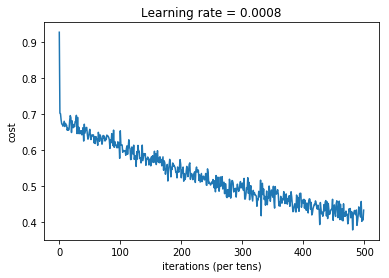

train accuracy: 0.9569377990430621
test accuracy: 0.74


In [24]:
parametersRegularized = modelRegularized(training_img, training_label, testing_img, testing_label, layerDims, actFunctions, keep_probs, lambd = 0., print_cost = True)

In [25]:
print("TRAINING SET, nonRegularized:")
try_decision(parametersNonRegularized, training_imgLoaded, training_label, display_img = False)

print("TRAINING SET, Regularized:")
try_decision(parametersRegularized, training_imgLoaded, training_label, display_img = False)

TRAINING SET, nonRegularized:
Accuracy: 0.9999999999999998
TRAINING SET, Regularized:
Accuracy: 0.9569377990430621


In [26]:
print("TESTING SET, nonRegularized:")
try_decision(parametersNonRegularized, testing_imgLoaded, testing_label, display_img = False)

print("TESTING SET, Regularized:")
try_decision(parametersRegularized, testing_imgLoaded, testing_label, display_img = False)

TESTING SET, nonRegularized:
Accuracy: 0.76
TESTING SET, Regularized:
Accuracy: 0.74
